In [1]:
import rasterio as rio
import numpy as np
import pandas as pd
import os
from pyproj import Proj # to get UTM coordinates from lat, lon
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# intialize projections:
TurnerProj = Proj("+proj=utm +zone=7 +hemisphere='N' +ellps=WGS84 +datum=WGS84 +units=m +no_defs") # UTM Zone 7N

In [2]:
basepath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/station-tracking/sIPR-projection/'
# os.listdir(basepath)

In [8]:
# # read in station install coordinates
# coords_df = pd.read_csv(basepath+'station_coords_20200904.csv', names=['lat','lon','station_name'])
# # convert coordinates to UTM
# UTMxs = []; UTMys = []
# for idx, row in coords_df.iterrows():
#     UTMx, UTMy = TurnerProj(row.lon, row.lat)
#     UTMxs.append(UTMx); UTMys.append(UTMy)
# coords_df['UTMx'] = UTMxs; coords_df['UTMy'] = UTMys
# coords_df.to_csv(basepath+'station_coords_20200904.csv')
# coords_df

/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/station-tracking/sIPR-projection/velocity_20200904_20200914_100m_S2.tif
     datetime station_name           UTMx          UTMy
0  2020-09-04         sIPR  570673.404688  6.658274e+06
1  2020-09-04     G12_2008  569370.887174  6.658913e+06
2  2020-09-04     G14_2008  567597.379098  6.660368e+06
3  2020-09-05         sIPR  570685.326563  6.658269e+06
4  2020-09-05     G12_2008  569382.762174  6.658908e+06
5  2020-09-05     G14_2008  567604.097848  6.660360e+06
6  2020-09-06         sIPR  570697.248438  6.658263e+06
7  2020-09-06     G12_2008  569394.637174  6.658903e+06
8  2020-09-06     G14_2008  567610.816598  6.660351e+06
9  2020-09-07         sIPR  570709.248438  6.658257e+06
10 2020-09-07     G12_2008  569406.605924  6.658898e+06
11 2020-09-07     G14_2008  567617.535348  6.660342e+06
12 2020-09-08         sIPR  570721.248438  6.658251e+06
13 2020-09-08     G12_2008  569418.574674  6.658892e+06
14 2020-09-08     G14_2008  567624.2

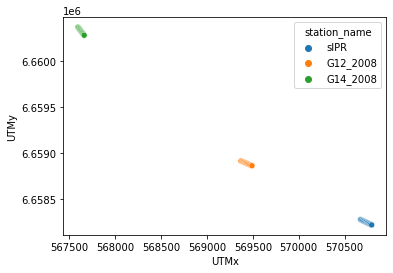

In [49]:
for file in os.listdir(basepath):
    if file.startswith('velocity_20200904') and file.endswith('.tif'): # SET START DATE HERE
        
        # grab map dates
        ds1 = file.split('_')[1]; ds2 = file.split('_')[2]
        d1 = datetime.datetime.strptime(ds1, '%Y%m%d')
        d2 = datetime.datetime.strptime(ds2, '%Y%m%d')
        dt = d2-d1; dt_days = dt.days # grab time separation
        
        # read in station install coordinates
        coords_df = pd.read_csv(basepath+'station_coords_'+ds1+'.csv',)
        
        # open the map
        print(basepath+file)
        mapreader = rio.open(basepath+file)
        vx_map = mapreader.read(1); vy_map = mapreader.read(2) # grab the x and y offset maps
        
        datetimes = []; xcoords = []; ycoords = []; station_names = []
        # grab the velocity values for each station each day - skip Nans!!
        for t in range(0, dt_days+1): # days after the start date
            t_date = d1+datetime.timedelta(days = t)
            for idx, row in coords_df.iterrows():
                x = row.UTMx; y = row.UTMy
                for val in mapreader.sample([(x, y)],indexes=(1,2)):
                    vx = val[0]/365; vy = val[1]/365 # grab vx, vy corresponding to that location in m/day
                coords_df.loc[idx,'UTMx'] = x + vx; coords_df.loc[idx, 'UTMy'] = y + vy # update coordinates
                # append to lists
                datetimes.append(t_date); xcoords.append(x+vx); ycoords.append(y+vy); 
                station_names.append(row.station_name)
        
        total_df = pd.DataFrame(list(zip(datetimes, station_names, xcoords, ycoords)), 
             columns=['datetime','station_name','UTMx','UTMy'])
        print(total_df)
        
        # Show movement over time frame:
        plt.figure(); plt.axes().set_aspect('equal'); 
        sns.scatterplot(x=total_df.UTMx, y=total_df.UTMy,hue=total_df.station_name);  plt.show()
        
        # save a new coordinates file:
        coords_df.to_csv(basepath+'station_coords_'+ds2+'.csv',index=False)
total_df.to_csv(basepath+'station_coords_daily_'+ds1+'_'+ds2+'.csv', index=False)